In [1]:
import pandas_datareader as pdr
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from IPython.display import display, HTML

In [4]:
from itertools import cycle, islice
class Port:
    def __init__(self,csv_path='port.csv'):
        self.df = pd.read_csv(csv_path,index_col='Symbol')
        assert self.df['Total'].describe().dtype.name == 'float64' , "Value in Total column must be float"
        assert self.df['Cost'].describe().dtype.name == 'float64' , "Value in Cost column must be number"
        assert self.df['Volume'].describe().dtype.name == 'float64' , "Value in Volume column must be number"
        assert self.df['Dividend'].describe().dtype.name == 'float64' , "Value in Dividend column must be number"
        self.total_cost = sum(self.df['Total'])
        self.updateLatestPrice()
        
    def chart(self,y="Total",title="Asset Allocation"):
        def func(pct, df):
            allvals = df['Total'].tolist()
            absolute = pct/100.*np.sum(allvals)
            index = [i for i in range(len(df['Total'].tolist())) if df['Total'].tolist()[i] == float("{:.2f}".format(absolute))]
            return "{:.1f}%\n{:.2f} ฿\n{:d} volume".format(pct, absolute,int(df.iloc[index[0]]['Volume']))
        self.df.plot.pie(y=y,title=title , autopct=lambda pct: func(pct, self.df),figsize=(12,12))
        return
    
    @staticmethod
    def getLatestPrice(symbol):
        separate = Port.getDataFromHTML(url='https://marketdata.set.or.th/mkt/stockquotation.do?symbol='+symbol +'&ssoPageId=1&language=th&country=TH')
        return float(separate.iloc[1][-1])
    def updateLatestPrice(self):
        for x in self.df.index:
            self.df.loc[x,'Latest'] = Port.getLatestPrice(x)
            self.df.loc[x,'Profit'] = float("{:.2f}".format((Port.getLatestPrice(x) - self.df.loc[x,'Cost'])*self.df.loc[x,'Volume']))
            self.df.loc[x,'Profit%'] = float("{:.2f}".format(self.df.loc[x,'Profit']*self.df.loc[x,'Cost']/100))
    def HPR(self):
        for x in self.df.index:
            self.df.loc[x,'HPR'] = (self.df.loc[x,'Dividend']+(self.df.loc[x,'Latest']-self.df.loc[x,'Cost']))/self.df.loc[x,'Cost']
            
    def saveToCSV(self):
        self.df.to_csv('port.csv')
        return 
    
    def describe(self):
        total_cost = float("{:.2f}".format(sum(self.df['Total'])))
        total_profit = float("{:.2f}".format(sum(self.df['Profit'])))
        values = self.df['Profit'].tolist()
        clrs = ['red' if (x < 0) else 'green' for x in values ]
        self.df.plot.bar(y="Profit",figsize=(12,5),title="Profit/Loss" ,color=clrs)
        display(HTML(self.df.to_html()))
        print("Cost   : {} BATH".format(total_cost),end=" | ")
        print("Profit : {} BATH".format(total_cost+total_profit),end=" | ")
        print("Relize : {} BATH".format(total_profit))
        self.chart(y="Total",title="asset allocation")
    
    @staticmethod
    def getDataFromHTML(url,index_col=''):
        try:
            if index_col != '':
                return pd.read_html(url,index_col=0)[0]
            else:
                return pd.read_html(url)[0]
        except:
            assert False, "โปรดตรวจสอบ URL ของท่าน"
        
    @staticmethod
    def CGD(symbol,DIV,g=8):
        try:
            int(DIV)
            int(g)
            
        except:
            assert False , "DIV and G must be number"
            
        if g==DIV:
            assert False , "DIV ต้องไม่เท่ากับ G"
                
        print("Instrinsic Value ของหุ้น {}".format(symbol))
        d = Port.getDataFromHTML(url='https://www.set.or.th/set/companyrights.do?symbol='+symbol+'&ssoPageId=7&language=th&country=TH',index_col=0)
        dividend = float(d.loc['เงินปันผล(บาท/หุ้น)']['เครื่องหมาย'].tolist()[0])
        DIV = DIV/100
        g = g/100
        V = (dividend*(1+g))/(DIV-g)
        print("ปันผลล่าสุด {}\nคาดว่าอัตราเติบโตของเงินปันผลจ่ายเท่ากับ {}\nอัตราผลตอบแทนที่ต้องการ {}".format(dividend,g,DIV))
        d = Port.getDataFromHTML(url='https://www.set.or.th/set/companyhighlight.do?symbol='+symbol+'&ssoPageId=5&language=th&country=TH',index_col=0)
        print("ราคาหุ้นปัจจุบัน {:.2f}".format(float(d.loc['ราคาล่าสุด(บาท)'].tolist()[-1])))
        print("Instrinsic Value (มูลค่าราคาหุ้น) : {:.2f}".format(V))
        print("----------------------------------------------")
        
    def getAdjClose(df):
        data = {}
        for x in df.index:
            data[x] = pdr.get_data_yahoo(x+'.BK')['Adj Close']
        data = pd.DataFrame(data)
        return data
    
    def PairTrade(df,symbol1,symbol2):
        data['diff'] = data[symbol1] - data[symbol2]
        d = data[[symbol1,symbol2,'diff']]
        d.plot()
        d.plot.hist(y='diff')
        d['mean'] = d['diff'].mean()
        d['-1SD'] = d['diff'].mean() - d['diff'].std()
        d['+1SD'] = d['diff'].mean() + d['diff'].std()
        d.plot(y=['diff','-1SD','mean','+1SD'])
        print("Mean : {} , SD : {} ".format(d['diff'].mean(),d['diff'].std()))
    
    
    def checkCGD_fromPort(self,div):
        for x in self.df.index:
            Port.CGD(x,div)

,Cost,Volume,Total,Dividend,Category,Latest,Profit,Profit%
Symbol,,,,,,,,
GPSC,81.64,2,163.28,0,พลังงานและสาธารณูปโภค,82.50,1.72,1.40
INTUCH,58.10,25,1452.50,0,เทคโนโลยีสารสนเทศและการสื่อสาร,57.50,-15.00,-8.71
PTT,39.82,4,159.28,0,พลังงานและสาธารณูปโภค,39.75,-0.28,-0.11
QH,2.34,100,234.00,0,พัฒนาอสังหาริมทรัพย์,2.34,0.00,0.00
TMB,1.17,400,468.00,0,ธนาคาร,1.16,-4.00,-0.05


Cost   : 2477.06 BATH | Profit : 2459.5 BATH | Relize : -17.56 BATH


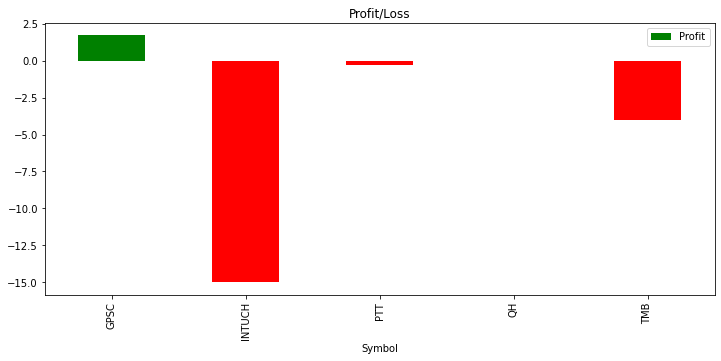

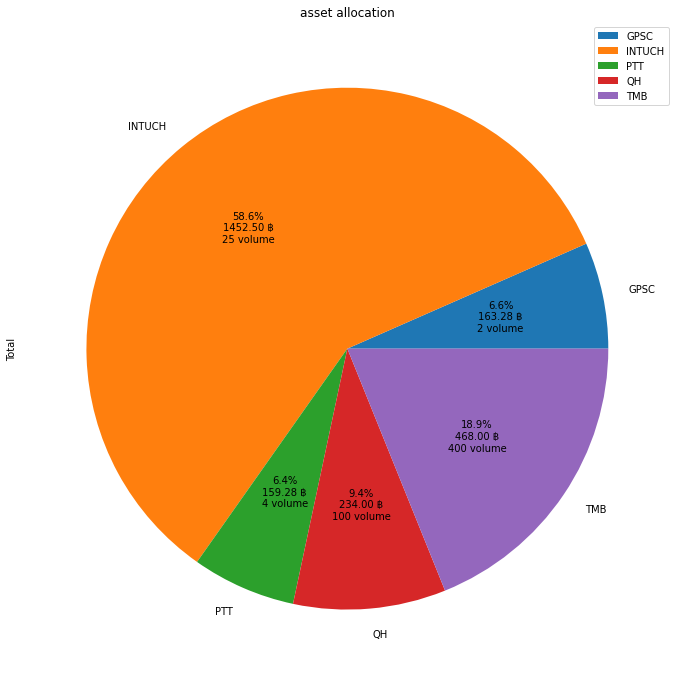

In [5]:
myPort = Port()
myPort.describe()

In [6]:
myPort.checkCGD_fromPort(div=10)

Instrinsic Value ของหุ้น GPSC
ปันผลล่าสุด 0.5
คาดว่าอัตราเติบโตของเงินปันผลจ่ายเท่ากับ 0.08
อัตราผลตอบแทนที่ต้องการ 0.1
ราคาหุ้นปัจจุบัน 81.50
Instrinsic Value (มูลค่าราคาหุ้น) : 27.00
----------------------------------------------
Instrinsic Value ของหุ้น INTUCH
ปันผลล่าสุด 1.15
คาดว่าอัตราเติบโตของเงินปันผลจ่ายเท่ากับ 0.08
อัตราผลตอบแทนที่ต้องการ 0.1
ราคาหุ้นปัจจุบัน 57.75
Instrinsic Value (มูลค่าราคาหุ้น) : 62.10
----------------------------------------------
Instrinsic Value ของหุ้น PTT
ปันผลล่าสุด 0.18
คาดว่าอัตราเติบโตของเงินปันผลจ่ายเท่ากับ 0.08
อัตราผลตอบแทนที่ต้องการ 0.1
ราคาหุ้นปัจจุบัน 40.00
Instrinsic Value (มูลค่าราคาหุ้น) : 9.72
----------------------------------------------
Instrinsic Value ของหุ้น QH
ปันผลล่าสุด 0.04
คาดว่าอัตราเติบโตของเงินปันผลจ่ายเท่ากับ 0.08
อัตราผลตอบแทนที่ต้องการ 0.1
ราคาหุ้นปัจจุบัน 2.34
Instrinsic Value (มูลค่าราคาหุ้น) : 2.16
----------------------------------------------
Instrinsic Value ของหุ้น TMB
ปันผลล่าสุด 0.01
คาดว่าอัตราเติบโตของเงินปัน